In [368]:
from HeaderP import *
from scipy import stats

def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./g'+simNo+'_z_0.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    if disk:
        data = data.loc[(data['decomp']==1)|(data['decomp']==4)].reset_index()
    return data

def normalize_data(data):
    return (data-np.mean(data))/np.std(data)

def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

def calcRbir_cv(data, fold=5):
    fold = int(fold)

    try:
        args = data['feh'], data['age'], data['Rg']
        args_name = '[Fe/H]', 'τ', '$R_g$'
    except:
        args = data['feh'], data['age'], data['R']
        args_name = '[Fe/H]', 'τ', 'R'
    
    X = list(args)
    X_names = list(args_name)
    
    for a, b in combinations_with_replacement(args, 2):
        X.append(a * b)

    
    for a, b in combinations_with_replacement(args_name, 2):
        X_names.append(str(a + '*' + b))
        
    X = np.array(X).T


    # Define the number of training and validating stars.
    Ntest = int(1./float(fold)*np.shape(X)[0])
    y = data['Rbir'].values
    ypred = np.zeros(len(y))
    
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
        
    weights = np.zeros((len(X_names)+1, fold))
        
    for i in range(fold):
        if i == fold-1:
            startind = int(-Ntest)
            endind = int(len(shuffle_inds)-1)
        else:
            startind = int(i*Ntest)
            endind = int(Ntest*(i+1))
            
        train_inds = np.append(shuffle_inds[:startind],shuffle_inds[endind:])
        test_inds = shuffle_inds[startind:endind]
        y_train, X_train = y[train_inds], X[train_inds, :]
        y_test, X_test = y[test_inds], X[test_inds, :]

        weights[:, i] = train(y_train, X_train)

        A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
        y_predict = np.dot(weights[:, i].T, A.T)
        ypred[test_inds] = y_predict

    return np.append(['$θ_C$'],X_names), [np.mean(weights[i,:]) for i in range(len(X_names)+1)], [np.std(weights[i,:]) for i in range(len(X_names)+1)], y, ypred

def calcRstd(data, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        data_loc = data.loc[(data['Rbir']>Rbirbin[i])&(data['Rbir']<Rbirbin[i+1])].reset_index(drop=True)
        Rstds[i] = np.std(data_loc['R']-data_loc['Rbir'])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def calcRstd_inf(infRbir, trueRbir, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    Rbias = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        m = (trueRbir>Rbirbin[i])&(trueRbir<Rbirbin[i+1])
        Rstds[i] = np.std(trueRbir[m]-infRbir[m])
        Rbias[i] = np.mean(infRbir[m])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rbias, Rstds

# Figure 1

In [369]:
simNo='7.55e11'
Rcut=True
Rcut_thread=30
zcut_thread=2.5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True)

Reading in simulation...


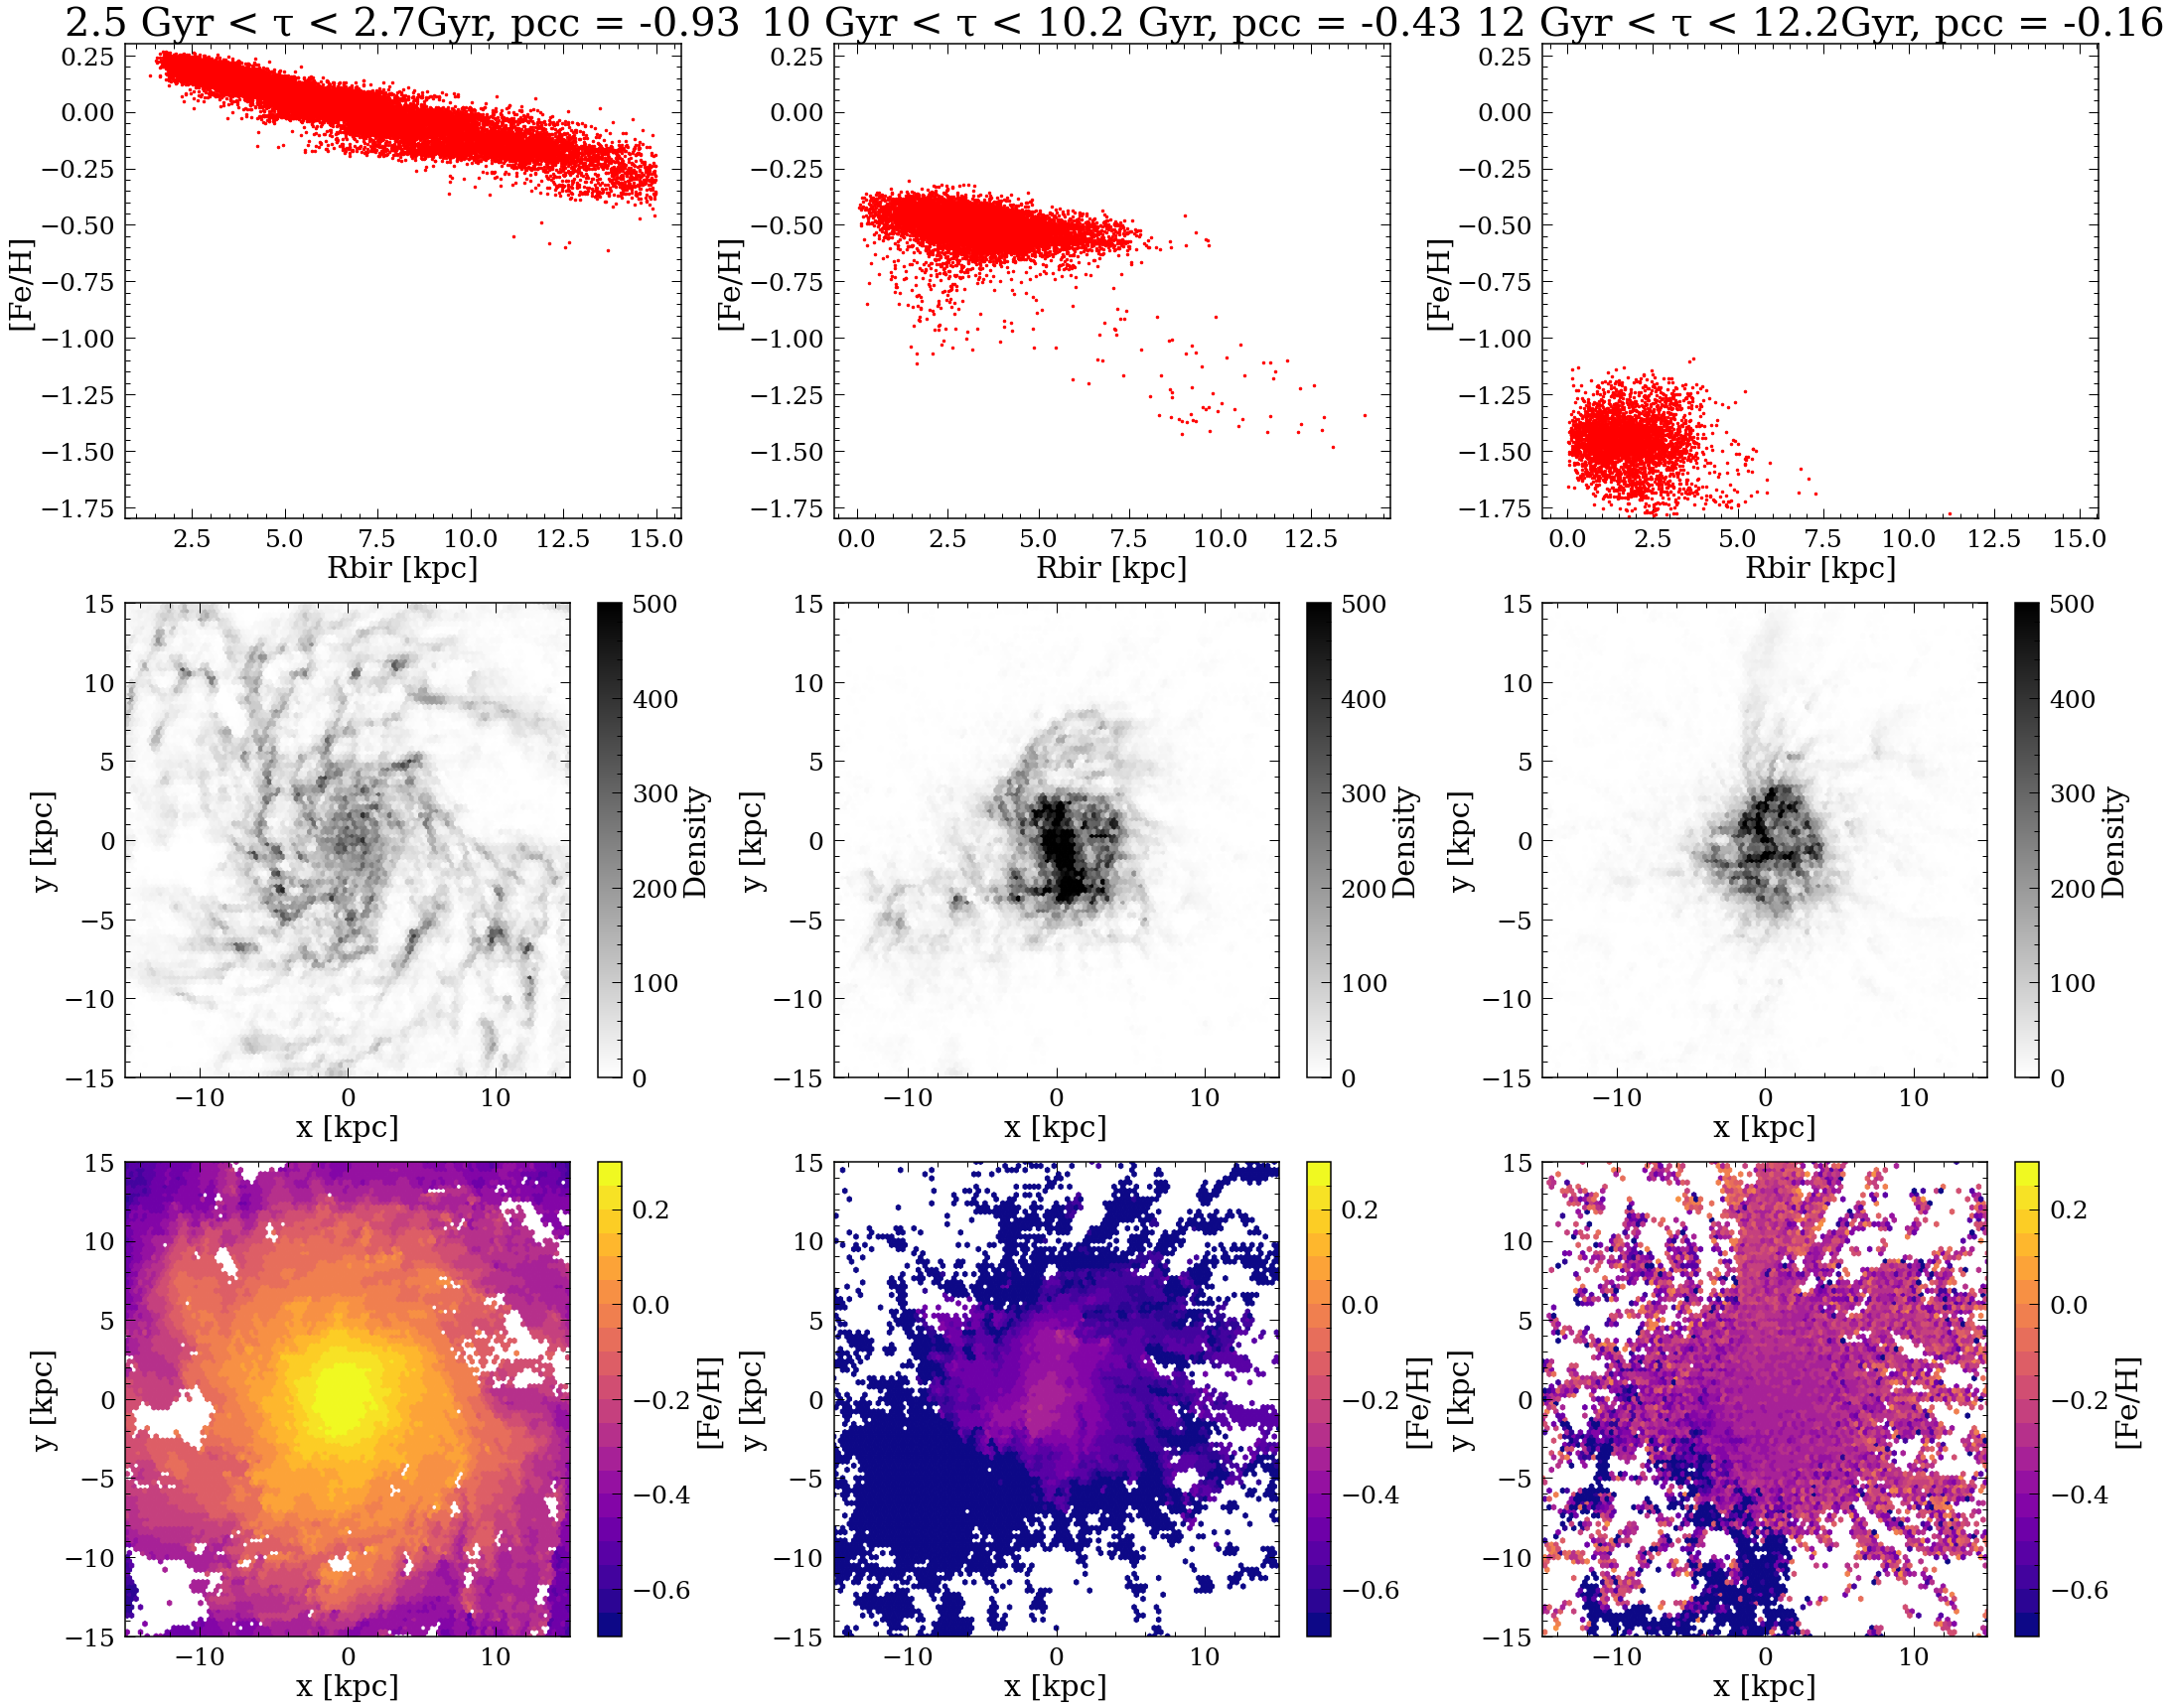

In [370]:


plt.figure(figsize=(30,24))
plt.subplot(3,3,1)

data_sing = data.loc[(data['age']>2.5)&(data['age']<2.7)]
plt.plot(data_sing['Rbir'],data_sing['feh'],'r.',markersize=5)
plt.xlabel('Rbir [kpc]')
plt.ylabel('[Fe/H]')
pc = stats.pearsonr(data_sing['Rbir'], data_sing['feh'])
plt.title('2.5 Gyr < τ < 2.7Gyr, pcc = %.2f'%pc[0], fontsize=40)
plt.ylim([-1.8, 0.3])

plt.subplot(3,3,2)
data_sing = data.loc[(data['age']>10)&(data['age']<10.2)]
plt.plot(data_sing['Rbir'],data_sing['feh'],'r.',markersize=5)
pc = stats.pearsonr(data_sing['Rbir'], data_sing['feh'])
plt.xlabel('Rbir [kpc]')
plt.ylabel('[Fe/H]')
plt.ylim([-1.8, 0.3])
plt.title('10 Gyr < τ < 10.2 Gyr, pcc = %.2f'%pc[0], fontsize=40)

plt.subplot(3,3,3)
data_sing = data.loc[(data['age']>12)&(data['age']<12.2)]
plt.plot(data_sing['Rbir'],data_sing['feh'],'r.',markersize=5)
pc = stats.pearsonr(data_sing['Rbir'], data_sing['feh'])
plt.xlabel('Rbir [kpc]')
plt.ylabel('[Fe/H]')
plt.ylim([-1.8, 0.3])
plt.title('12 Gyr < τ < 12.2Gyr, pcc = %.2f'%pc[0], fontsize=40)

plt.subplot(3,3,4)
data_snap = pd.read_pickle('g7.55e11_3x9/7.55e11.00840_gas.pkl')
plt.hexbin(data_snap['x'],data_snap['y'],gridsize=100,extent=(-15,15,-15,15),mincnt=1,
           cmap=plt.cm.get_cmap('binary'), vmin=0, vmax=500)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.xlim([-15,15])
plt.ylim([-15,15])
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(3,3,5)
data_snap = pd.read_pickle('g7.55e11_3x9/7.55e11.00296_gas.pkl')
plt.hexbin(data_snap['x'],data_snap['y'],gridsize=100,extent=(-15,15,-15,15),mincnt=1,
           cmap=plt.cm.get_cmap('binary'), vmin=0, vmax=500)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.xlim([-15,15])
plt.ylim([-15,15])
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(3,3,6)
data_snap = pd.read_pickle('g7.55e11_3x9/7.55e11.00152_gas.pkl')
plt.hexbin(data_snap['x'],data_snap['y'],gridsize=100,extent=(-15,15,-15,15),mincnt=1,
           cmap=plt.cm.get_cmap('binary'), vmin=0, vmax=500)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.xlim([-15,15])
plt.ylim([-15,15])
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(3,3,7)
data_snap = pd.read_pickle('g7.55e11_3x9/7.55e11.00840_gas.pkl')
plt.hexbin(data_snap['x'],data_snap['y'],C=data_snap['feh'],gridsize=100,extent=(-15,15,-15,15),mincnt=1,
           cmap=plt.cm.get_cmap('plasma',20), vmin=-0.7, vmax=0.3)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.xlim([-15,15])
plt.ylim([-15,15])
cb = plt.colorbar()
cb.set_label('[Fe/H]')

plt.subplot(3,3,8)
data_snap = pd.read_pickle('g7.55e11_3x9/7.55e11.00296_gas.pkl')
plt.hexbin(data_snap['x'],data_snap['y'],C=data_snap['feh'],gridsize=100,extent=(-15,15,-15,15),mincnt=1,
           cmap=plt.cm.get_cmap('plasma',20), vmin=-0.7, vmax=0.3)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.xlim([-15,15])
plt.ylim([-15,15])
cb = plt.colorbar()
cb.set_label('[Fe/H]')

plt.subplot(3,3,9)
data_snap = pd.read_pickle('g7.55e11_3x9/7.55e11.00152_gas.pkl')
plt.hexbin(data_snap['x'],data_snap['y'],C=data['feh'],gridsize=100,extent=(-15,15,-15,15),mincnt=1,
           cmap=plt.cm.get_cmap('plasma',20), vmin=-0.7, vmax=0.3)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.xlim([-15,15])
plt.ylim([-15,15])
cb = plt.colorbar()
cb.set_label('[Fe/H]')

plt.tight_layout()
plt.savefig('LetterFig/fehrelation.png',bbox_inches='tight')

# Figure 2

Reading in simulation...
Reading in simulation...
Reading in simulation...
Reading in simulation...


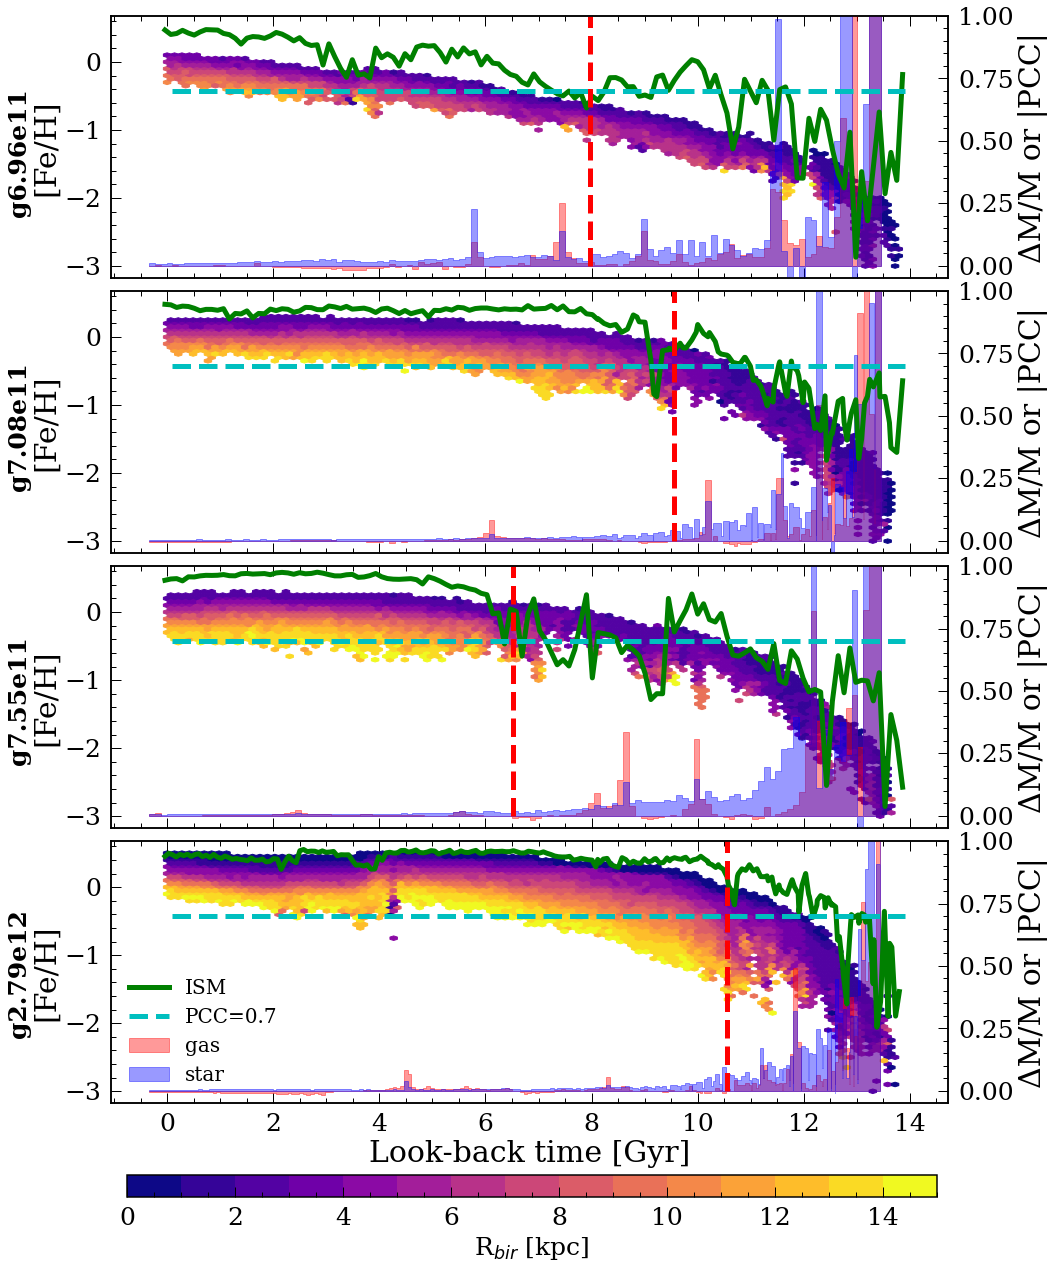

In [577]:
import warnings
warnings.filterwarnings("ignore")

masses = [6.96e11, 7.08e11, 7.55e11, 2.79e12]
filenames = ['696e11','708e11', '755e11', '279e12']
titlenames = ['6.96e11','7.08e11','7.55e11','2.79e12']

fig, axarr = plt.subplots(4,1, gridspec_kw={'hspace': 0.05, 'wspace': 0.0}, 
                          figsize=(15,20))
for i in range(len(masses)):
    ages = np.load('age_g'+filenames[i]+'.npy')
    fehs = np.load('feh_g'+filenames[i]+'.npy')
    rbirn = np.load('normRbir_g'+filenames[i]+'.npy')
    
    simNo=titlenames[i]
    Rcut=False
    Rcut_thread=30
    zcut_thread=2.5

    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True)


    im = axarr[i].hexbin(data['age'], data['feh'], C=data['Rbir'],
                         extent=(0,14,-3,0.5),gridsize=(100,35), mincnt=1, 
               cmap=plt.cm.get_cmap('plasma',15), vmin=0, vmax=15)
    axarr[i].set_ylabel('[Fe/H]')
    
    newax = axarr[i].twinx()
    times = np.load('pctime_g'+filenames[i]+'.npy')
    pcs = np.load('pc_g'+filenames[i]+'.npy')
    pcs_rbir = np.load('pc_Rbir_g'+filenames[i]+'.npy')
    
    df = pd.read_pickle('ISM_slope_g'+filenames[i]+'.pkl')
    df = df.sort_values('time')
    df['diffmass'] = np.append([0], np.diff(df['M_gas_hlr2'].values)/(df['M_gas_hlr2'].values[:-1]))
    df['diffmass_star'] = np.append([0], np.diff(df['M_star_hlr2'].values)/(df['M_star_hlr2'].values[:-1]))
    df['diffslope'] = np.append([0], np.diff(df['slope'].values))
    
    
    newax.plot(14.1-df['time'], abs(df['pcc']), 'g-', linewidth=5, label='ISM')
    #newax.plot(times, abs(pcs_rbir), 'y-', linewidth=5, label='Stellar')
    newax.plot(times, np.ones(len(times))*0.7, 'c--', linewidth=5, label='PCC=0.7')
    if filenames[i]=='755e11':
        newax.plot([6.526,6.526], [0,1], 'r--', linewidth=5)
    elif filenames[i]=='696e11':
        newax.plot([7.975,7.975], [0,1], 'r--', linewidth=5)
    elif filenames[i]=='708e11':
        newax.plot([9.559,9.559], [0,1], 'r--', linewidth=5)
    elif filenames[i]=='279e12':
        newax.plot([10.550,10.550], [0,1], 'r--', linewidth=5)
        
    newax.set_ylim([0,1])

    
    newax.fill_between(13.8-df['time'], df['diffmass'], step="pre", alpha=0.4,label='gas',color='r')
    newax.fill_between(13.8-df['time'], df['diffmass_star'], step="pre", alpha=0.4,label='star', color='b')
    
    newax.set_ylim([-0.05,1])
    newax.set_ylabel('ΔM/M or |PCC|')
    
    if i!=3:
        axarr[i].set_xticklabels([])
    if i==3:
        axarr[i].set_xlabel('Look-back time [Gyr]')
        newax.legend(loc=3, fontsize=20)
        
cb_ax = fig.add_axes([0.14, 0.06, 0.75, 0.015])
cbar = fig.colorbar(im, cax=cb_ax,orientation = 'horizontal')
car = cbar.set_label('R$_{bir}$ [kpc]',fontsize = 25,labelpad = 5)

fig.text(0.04, 0.215, 'g2.79e12', ha='center', va='center', rotation='vertical',fontsize=25,weight='bold')
fig.text(0.04, 0.405, 'g7.55e11', ha='center', va='center', rotation='vertical',fontsize=25,weight='bold')
fig.text(0.04, 0.595, 'g7.08e11', ha='center', va='center', rotation='vertical',fontsize=25,weight='bold')
fig.text(0.04, 0.785, 'g6.96e11', ha='center', va='center', rotation='vertical',fontsize=25,weight='bold')

plt.tight_layout()
plt.savefig('LetterFig/Allfeh.png',bbox_inches='tight')
    

# Figure 3

(-0.6523355168374919, 4.4190904654089946e-18)
(-0.5854518381129468, 4.640312483761188e-14)


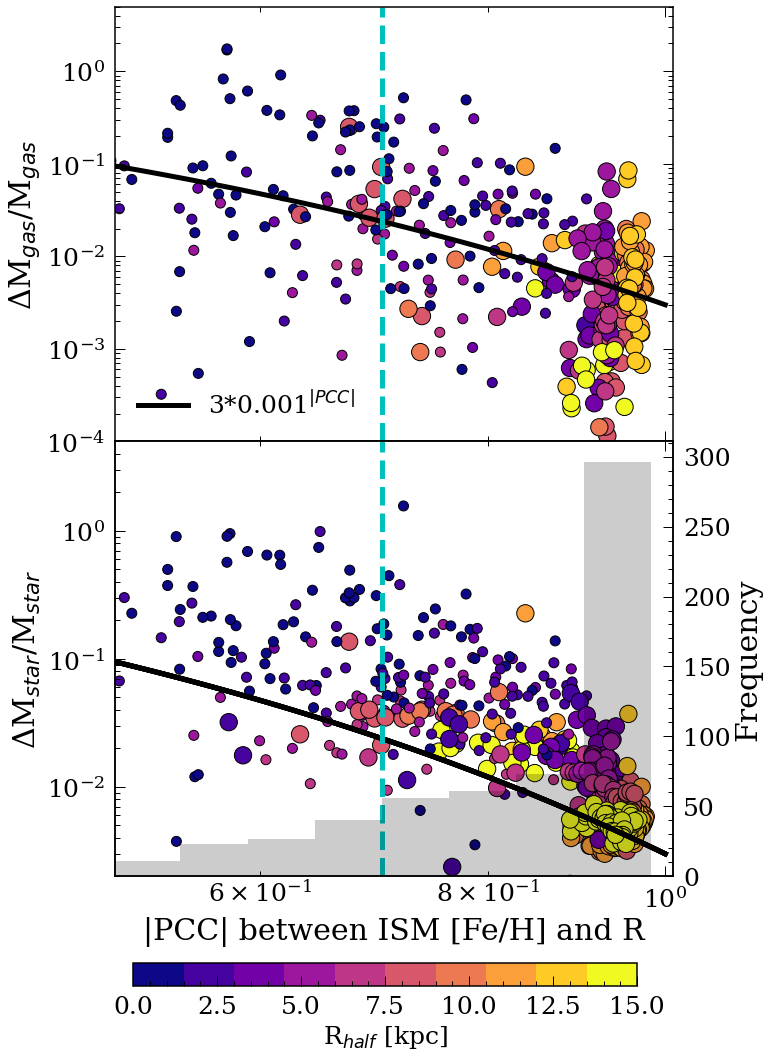

In [561]:
import warnings
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
warnings.filterwarnings("ignore")
cmap=plt.cm.get_cmap('plasma',10)
masses = [6.96e11, 7.08e11, 7.55e11, 2.79e12]
filenames = ['696e11','708e11', '755e11', '279e12']
titlenames = ['6.96e11','7.08e11','7.55e11','2.79e12']

fig, axarr = plt.subplots(2,1, gridspec_kw={'hspace': 0, 'wspace': 0}, 
                          figsize=(10,16))
axarr[0].set_xticklabels([])
allpc_rbir = np.zeros(1)
alldg_rbir = np.zeros(1)
disksizes_rbir = np.zeros(1)
allds_rbir = np.zeros(1)

allpc = np.zeros(1)
alldg = np.zeros(1)
allds = np.zeros(1)
disksize = np.zeros(1)

for i in range(len(masses)):
    pcs_rbir = np.load('pc_Rbir_g'+filenames[i]+'.npy')
    pcs = np.load('pc_g'+filenames[i]+'.npy')
    
    df = pd.read_pickle('ISM_slope_g'+filenames[i]+'.pkl')
    df['diffmass'] = np.append([0], np.diff(df['M_gas_hlr2'].values)/(df['M_gas_hlr2'].values[:-1]))
    df['diffmass_star'] = np.append([0], np.diff(df['M_star_hlr2'].values)/(df['M_star_hlr2'].values[:-1]))
    df['time'] = 14.1-df['time']
    
    disksize = np.load('disksize_g'+filenames[i]+'.npy')

    times = np.load('pctime_g'+filenames[i]+'.npy')
    
    if filenames[i]=='755e11':
        diskm = times>6.526
        diskm_ism = df['time']>6.526
    elif filenames[i]=='696e11':
        diskm = times>7.975
        diskm_ism = df['time']>7.975
    elif filenames[i]=='708e11':
        diskm = times>9.559
        diskm_ism = df['time']>9.559
    elif filenames[i]=='279e12':
        diskm = times>10.550
        diskm_ism = df['time']>10.550
        
        
    pc_rbir_bintime = np.load('pc_bintime_g'+filenames[i]+'.npy')
    diffgas_rbir = np.load('diffgas_Rbir_g'+filenames[i]+'.npy')
    diffstar_rbir = np.load('diffstar_Rbir_g'+filenames[i]+'.npy')
    disksize_rbir = np.load('disksize_sort_g'+filenames[i]+'.npy')
    
    
    pc_rg_bintime = df['pcc'].values
    diffgas_rg = df['diffmass'].values
    diffstar_rg = df['diffmass_star'].values
    disksize_rg = df['half_mass_l2'].values/1000
    
    allpc_rbir = np.append(allpc_rbir, abs(pc_rbir_bintime))
    alldg_rbir = np.append(alldg_rbir, diffgas_rbir)
    allds_rbir = np.append(allds_rbir, diffstar_rbir)
    disksizes_rbir = np.append(disksizes_rbir, np.log(disksize_rbir))
    
    allpc = np.append(allpc, abs(pc_rg_bintime))
    alldg = np.append(alldg, diffgas_rg)
    allds = np.append(allds, diffstar_rg)
    disksize = np.append(disksize, disksize_rg)
    
    im = axarr[0].scatter(abs(pc_rg_bintime)[diskm_ism], diffgas_rg[diskm_ism], 
                       c=disksize_rg[diskm_ism], 
                       s=100, vmin=0, vmax=15,cmap=cmap,edgecolor='k')
    
     
    axarr[1].scatter(abs(pc_rg_bintime)[diskm_ism], diffstar_rg[diskm_ism], 
                       c=disksize_rg[diskm_ism], 
                       s=100, vmin=0, vmax=15,cmap=cmap,edgecolor='k')
    
    
    axarr[0].scatter(abs(pc_rg_bintime)[~diskm_ism], diffgas_rg[~diskm_ism], 
                       c=disksize_rg[~diskm_ism], 
                       s=300, vmin=0, vmax=15,cmap=cmap,edgecolor='k')
     
    axarr[1].scatter(abs(pc_rg_bintime)[~diskm_ism], diffstar_rg[~diskm_ism], 
                       c=disksize_rg[~diskm_ism], 
                       s=300, vmin=0, vmax=15,cmap=cmap,edgecolor='k')
    
   

    allpcs = np.linspace(1e-4, 1, 100)
    axarr[1].plot(allpcs, 0.001**(allpcs)*3,'k-',linewidth=5)

allpcs = np.linspace(1e-4, 1, 100)
axarr[0].plot(allpcs, 0.001**(allpcs)*3,'k-',linewidth=5,label='3*0.001$^{|PCC|}$')
axarr[0].legend(loc=3) 
axarr[1].plot(allpcs, 0.001**(allpcs)*3,'k-',linewidth=5)

axarr[1].set_yscale('log')
axarr[0].set_xscale('log')
axarr[1].set_xscale('log')
axarr[0].set_yscale('log')

axarr[0].set_ylabel('ΔM$_{gas}$/M$_{gas}$')
axarr[1].set_ylabel('ΔM$_{star}$/M$_{star}$')


axarr[0].set_xlim([5e-1,1.01])
axarr[1].set_xlim([5e-1,1.01])


axarr[0].set_ylim([1e-4,5])
axarr[1].set_ylim([2e-3,5])

axarr[0].plot([0.7,0.7],[1e-4,5],'c--',linewidth=5)
axarr[1].plot([0.7,0.7],[2e-3,5],'c--',linewidth=5)

axarr[1].set_xlabel('|PCC| between ISM [Fe/H] and R')


axarr[0].set_xticklabels([])
axarr[0].xaxis.set_minor_locator(MultipleLocator(2e-1))
    
newaxis2 = axarr[1].twinx()
newaxis2.hist(allpc, bins=np.logspace(np.log10(3e-1),np.log10(1.5),20), 
              color='k', alpha=0.2)
newaxis2.set_ylabel('Frequency')
newaxis2.xaxis.set_minor_locator(MultipleLocator(2e-1))
    
cb_ax = fig.add_axes([0.15, 0.03, 0.7, 0.02])
cbar = fig.colorbar(im, cax=cb_ax,orientation = 'horizontal')
car = cbar.set_label('R$_{half}$ [kpc]',fontsize = 25,labelpad = 5)
    

plt.savefig('LetterFig/correlation.png',bbox_inches='tight')
    
dfpcc = pd.DataFrame(np.array((np.log(abs(pc_rg_bintime)), np.log(diffstar_rg),
                              np.log(diffgas_rg))).T,
                    columns=['pc','diffstar','diffgas'])
dfpcc = dfpcc.dropna()
print(stats.pearsonr(dfpcc['pc'],dfpcc['diffstar']))
print(stats.pearsonr(dfpcc['pc'],dfpcc['diffgas']))


# Figure 4

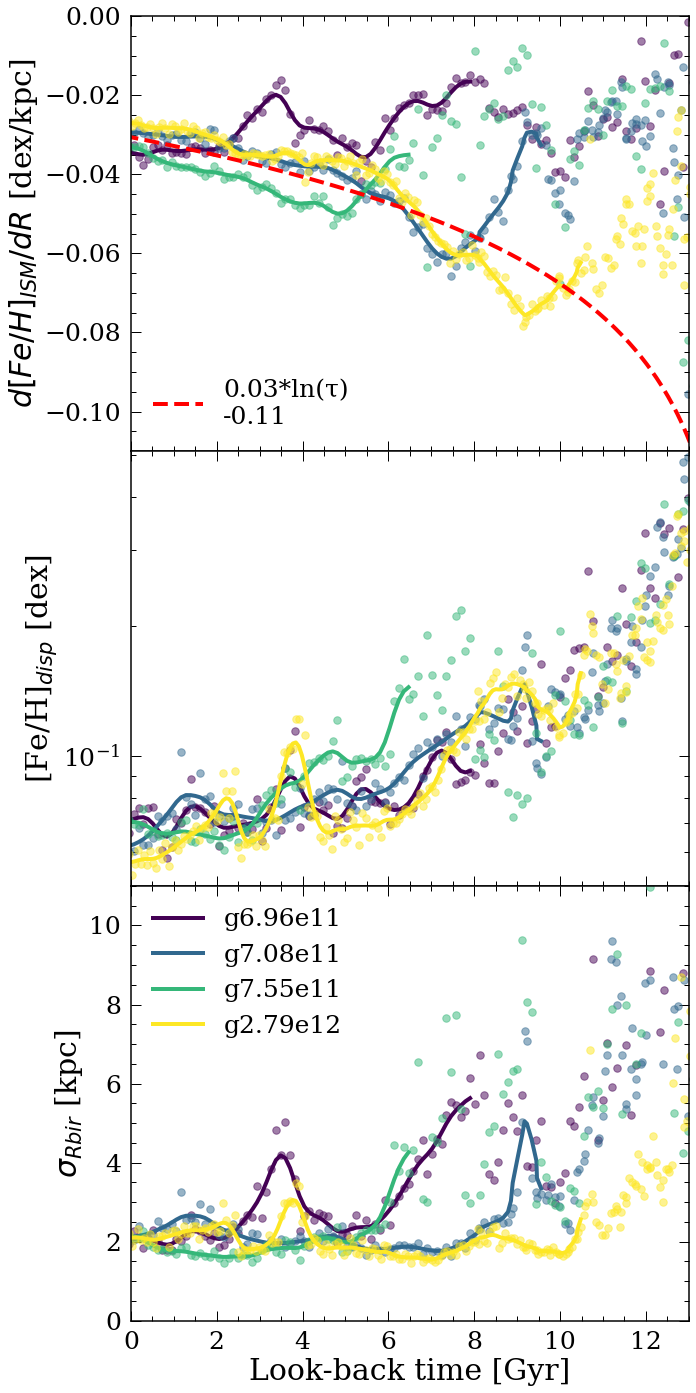

In [574]:
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import matplotlib

def getcolor(vrange,cm=plt.cm.get_cmap('viridis')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]

colors = getcolor(range(4))

def loge(x, a, b):
    return a*np.log(x)+b

fig, axarr = plt.subplots(3,1, gridspec_kw={'hspace': 0, 'wspace': 0}, 
                          figsize=(10,24))

sims = ['g6.96e11_3x9','g7.08e11_5x10','g7.55e11_3x9','g2.79e12_3x6']
        
for i in range(len(sims)):
    name = ''
    for k in sims[i].split('_')[0].split('.'):
        name = name+k
    if name == 'g112e12':
        continue
    df = pd.read_pickle('ISM_slope_'+name+'.pkl')

    #m=df['time']>5
    #df = df[m].reset_index(drop=True)
    
    if sims[i]=='g7.55e11_3x9':
        diskm_ism = df['time']>14.1-6.526
    elif sims[i]=='g6.96e11_3x9':
        diskm_ism = df['time']>14.1-7.975
    elif sims[i]=='g7.08e11_5x10':
        diskm_ism = df['time']>14.1-9.559
    elif sims[i]=='g2.79e12_3x6':
        diskm_ism = df['time']>14.1-10.550
        
    
    axarr[0].plot(14.1-df['time'].values, 
                  df['slope'].values,
                  '.',color=colors[i],markersize=15,alpha=0.5)
    
    slopes = gaussian_filter1d(df['slope'].values, 2)
    axarr[0].plot(14.1-df['time'].values[diskm_ism], slopes[diskm_ism],
                  '-',color=colors[i],linewidth=4)
    """
    axarr[0].plot(df['time'].values[~diskm_ism], slopes[~diskm_ism],
                  '--',color=colors[i],linewidth=2)
    """
    """
    m = df['time']>10
    popt, pcov = curve_fit(loge, df['time'].values[m], df['time'].values[m],
                           bounds=[[0,-10],[0.5,1]])
    print(popt)
    """
axarr[0].plot(14.1-df['time'].values, loge(df['time'].values,0.03,-0.11),
              'r--',linewidth=4, label='0.03*ln(τ)\n-0.11')


    
axarr[0].set_xlabel('Look-back time [Gyr]')
axarr[0].set_ylabel('$d[Fe/H]_{ISM}/dR$ [dex/kpc]')

for i in range(len(sims)):
    name = ''
    for k in sims[i].split('_')[0].split('.'):
        name = name+k
    if name == 'g112e12':
        continue
    df = pd.read_pickle('ISM_slope_'+name+'.pkl')
    
    #m=df['time']>5
    #df = df[m].reset_index(drop=True)
    
    if sims[i]=='g7.55e11_3x9':
        diskm_ism = df['time']>14.1-6.526
    elif sims[i]=='g6.96e11_3x9':
        diskm_ism = df['time']>14.1-7.975
    elif sims[i]=='g7.08e11_5x10':
        diskm_ism = df['time']>14.1-9.559
    elif sims[i]=='g2.79e12_3x6':
        diskm_ism = df['time']>14.1-10.550
        
        
    name = name[:2]+'.'+name[2:]
    axarr[1].plot(14.1-df['time'].values, df['residual'].values,'.',
                  color=colors[i],markersize=15,alpha=0.5)
    slopes = gaussian_filter1d(df['residual'].values, 2)
    axarr[1].plot(14.1-df['time'].values[diskm_ism], slopes[diskm_ism],
                  '-',color=colors[i],label=name,linewidth=4)
    axarr[1].yaxis.set_minor_locator(MultipleLocator(1e-1))
    """
    axarr[1].plot(df['time'].values[~diskm_ism], slopes[~diskm_ism],
                   '--',color=colors[i],linewidth=1)
    """
    
for i in range(len(sims)):
    name = ''
    for k in sims[i].split('_')[0].split('.'):
        name = name+k
    if name == 'g112e12':
        continue
    df = pd.read_pickle('ISM_slope_'+name+'.pkl')
    
    #m=df['time']>5
    #df = df[m].reset_index(drop=True)
    
    if sims[i]=='g7.55e11_3x9':
        diskm_ism = df['time']>14.1-6.526
    elif sims[i]=='g6.96e11_3x9':
        diskm_ism = df['time']>14.1-7.975
    elif sims[i]=='g7.08e11_5x10':
        diskm_ism = df['time']>14.1-9.559
    elif sims[i]=='g2.79e12_3x6':
        diskm_ism = df['time']>14.1-10.550
        
        
    name = name[:2]+'.'+name[2:]
    axarr[2].plot(14.1-df['time'].values, df['residual'].values/abs(df['slope'].values),'.',
                  color=colors[i],markersize=15,alpha=0.5)
    slopes = gaussian_filter1d(df['residual'].values/abs(df['slope'].values), 2)
    axarr[2].plot(14.1-df['time'].values[diskm_ism], slopes[diskm_ism],
                  '-',color=colors[i],label=name,linewidth=4)

axarr[1].set_ylabel('[Fe/H]$_{disp}$ [dex]')  
axarr[1].set_xticklabels([])  
axarr[0].legend()

axarr[0].set_ylim([-0.11,0])
axarr[1].set_ylim([0.05, 0.51])
axarr[0].set_xlim([0,13])
axarr[1].set_xlim([0,13])

axarr[2].set_xlabel('Look-back time [Gyr]')
axarr[2].set_ylabel('$σ_{Rbir}$ [kpc]')  
axarr[0].legend()
axarr[2].legend()

axarr[2].set_ylim([0,11])
axarr[2].set_xlim([0,13])

axarr[1].set_yscale('log')

axarr[0].set_xticklabels([])
plt.savefig('LetterFig/slopeassump.png',bbox_inches='tight')


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

(-0.6523355168374919, 4.4190904654089946e-18)
(-0.5854518381129468, 4.640312483761188e-14)


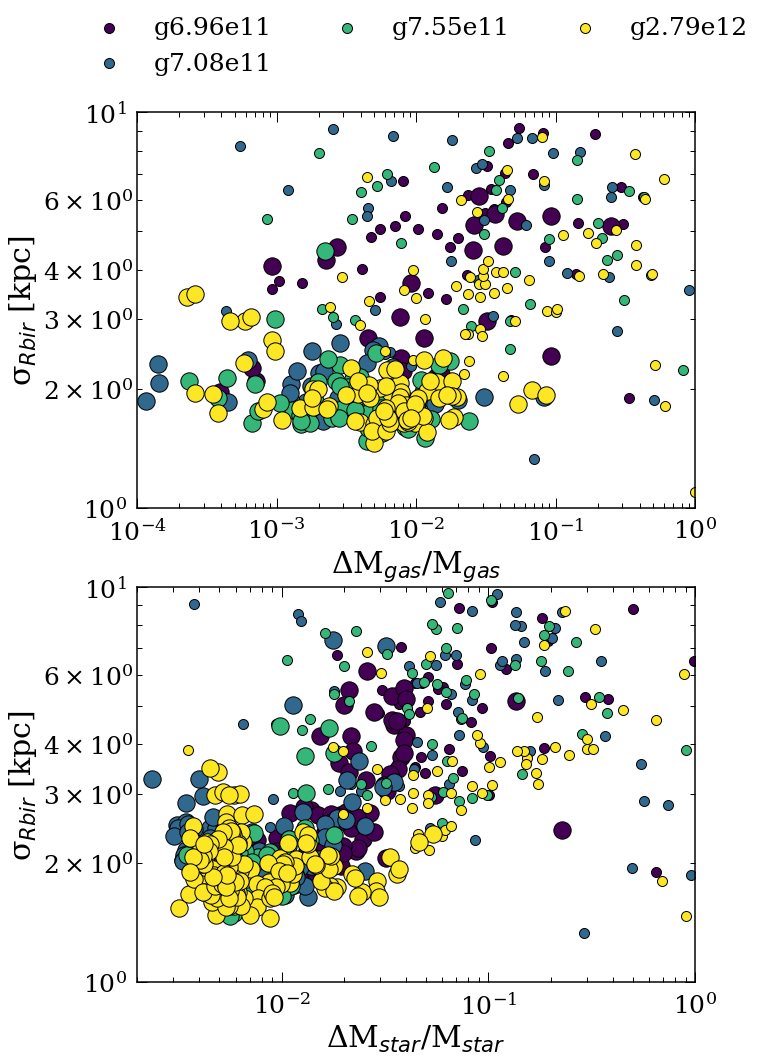

In [572]:
import warnings
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
warnings.filterwarnings("ignore")
cmap=plt.cm.get_cmap('plasma',10)
masses = [6.96e11, 7.08e11, 7.55e11, 2.79e12]
filenames = ['696e11','708e11', '755e11', '279e12']
titlenames = ['6.96e11','7.08e11','7.55e11','2.79e12']

fig, axarr = plt.subplots(2,1, gridspec_kw={'hspace': 0.2, 'wspace': 0}, 
                          figsize=(10,16))
axarr[0].set_xticklabels([])
allpc_rbir = np.zeros(1)
alldg_rbir = np.zeros(1)
disksizes_rbir = np.zeros(1)
allds_rbir = np.zeros(1)

allpc = np.zeros(1)
alldg = np.zeros(1)
allds = np.zeros(1)
disksize = np.zeros(1)

for i in range(len(masses)):
    name = ''
    for k in sims[i].split('_')[0].split('.'):
        name = name+k
    if name == 'g112e12':
        continue
        
    pcs_rbir = np.load('pc_Rbir_g'+filenames[i]+'.npy')
    pcs = np.load('pc_g'+filenames[i]+'.npy')
    
    df = pd.read_pickle('ISM_slope_g'+filenames[i]+'.pkl')
    df['diffmass'] = np.append([0], np.diff(df['M_gas_hlr2'].values)/(df['M_gas_hlr2'].values[:-1]))
    df['diffmass_star'] = np.append([0], np.diff(df['M_star_hlr2'].values)/(df['M_star_hlr2'].values[:-1]))
    df['Rbirerr'] = df['residual'].values/abs(df['slope'].values)
    df['time'] = 14.1-df['time']
    
    disksize = np.load('disksize_g'+filenames[i]+'.npy')

    times = np.load('pctime_g'+filenames[i]+'.npy')
    
    if filenames[i]=='755e11':
        diskm = df['time']>6.526
    elif filenames[i]=='696e11':
        diskm = df['time']>7.975
    elif filenames[i]=='708e11':
        diskm = df['time']>9.559
    elif filenames[i]=='279e12':
        diskm = df['time']>10.550
        
    
    name = name[:2]+'.'+name[2:]
    im = axarr[0].scatter(df['diffmass'][diskm], df['Rbirerr'][diskm], 
                       c=colors[i], 
                       s=100, vmin=0, vmax=15,cmap=cmap,edgecolor='k',
                         label=name)
    
     
    axarr[1].scatter(df['diffmass_star'][diskm], df['Rbirerr'][diskm], 
                       c=colors[i], label=name,
                       s=100, vmin=0, vmax=15,cmap=cmap,edgecolor='k')
    
    
    axarr[0].scatter(df['diffmass'][~diskm], df['Rbirerr'][~diskm], 
                       c=colors[i], 
                       s=300, vmin=0, vmax=15,cmap=cmap,edgecolor='k')
     
    axarr[1].scatter(df['diffmass_star'][~diskm], df['Rbirerr'][~diskm], 
                       c=colors[i], 
                       s=300, vmin=0, vmax=15,cmap=cmap,edgecolor='k')


axarr[1].set_yscale('log')
axarr[0].set_xscale('log')
axarr[1].set_xscale('log')
axarr[0].set_yscale('log')

axarr[0].set_ylabel('σ$_{Rbir}$ [kpc]')
axarr[1].set_ylabel('σ$_{Rbir}$ [kpc]')


axarr[0].set_xlim([1e-4,1])
axarr[1].set_xlim([2e-3,1])


axarr[0].set_ylim([1,10])
axarr[1].set_ylim([1,10])


axarr[1].set_xlabel('ΔM$_{star}$/M$_{star}$')
axarr[0].set_xlabel('ΔM$_{gas}$/M$_{gas}$')

axarr[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=3, fancybox=True)
    
#cb_ax = fig.add_axes([0.15, 0.03, 0.7, 0.02])
#cbar = fig.colorbar(im, cax=cb_ax,orientation = 'horizontal')
#car = cbar.set_label('R$_{half}$ [kpc]',fontsize = 25,labelpad = 5)
    

plt.savefig('LetterFig/sigmar.png',bbox_inches='tight')
    
dfpcc = pd.DataFrame(np.array((np.log(abs(pc_rg_bintime)), np.log(diffstar_rg),
                              np.log(diffgas_rg))).T,
                    columns=['pc','diffstar','diffgas'])
dfpcc = dfpcc.dropna()
print(stats.pearsonr(dfpcc['pc'],dfpcc['diffstar']))
print(stats.pearsonr(dfpcc['pc'],dfpcc['diffgas']))

